In [44]:
import os  # dealing with directories
import cv2  # working with, mainly resizing, images
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image as im
import random
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings('ignore')

### Uploading the images

<B> I got the uploading images idea from kaggle notebook

In [2]:
train_directory = r'/Users/idobar/Documents/GitHub/FirstFinal/train/'
train_filepath = [train_directory + last_file_name for last_file_name in os.listdir(train_directory)]
train_dogs_filepath = [train_directory + dog_file_name for dog_file_name in os.listdir(train_directory) if 'dog' in dog_file_name]
train_cats_filepath = [train_directory + cat_file_name for cat_file_name in os.listdir(train_directory) if 'cat' in cat_file_name]

In [3]:
def read_image(file_path):
    #grayscaling
    img = cv2.imread(file_path,0)
    #resizing the images to 64,64 in order to get all the images in the same size
    return cv2.resize(img, (64, 64))

In [4]:
def prep_data(images):
    image_len = len(images)
    size = 4096 #64*64
    X = np.ndarray((image_len, size), dtype=np.uint8)
    y = np.zeros((image_len, 1))
    for i, image_file in enumerate(images):
        # Sending the image to the read_image function 
        image = read_image(image_file)
        X[i, :] = np.squeeze(image.reshape((size, 1)))
        # The value will be 1 for dog and 0 for cat
        if '/dog' in image_file:
            y[i, 0] = 1
        elif '/cat' in image_file:
             y[i, 0] = 0
    return X, y

In [5]:
data,target = prep_data(train_filepath)

In [6]:
df = pd.DataFrame(data)
target=pd.DataFrame(target,columns = ['labels'])

<B> After successfully uploading the images lets do some visualization

### Visualization

In [7]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,4086,4087,4088,4089,4090,4091,4092,4093,4094,4095
0,19,47,26,58,49,73,70,68,71,73,...,49,53,36,30,34,41,51,54,58,52
1,96,104,114,112,110,111,111,113,116,115,...,117,98,141,117,121,120,113,107,26,49
2,70,157,180,181,189,164,141,146,149,198,...,114,110,112,95,93,87,85,81,68,68
3,26,25,26,28,27,27,35,28,28,27,...,61,22,35,30,39,36,26,52,46,42
4,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255


In [8]:
df.tail()

,0,1,2,3,4,5,6,7,8,9,...,4086,4087,4088,4089,4090,4091,4092,4093,4094,4095
24995,24,25,28,31,25,28,24,26,40,44,...,76,72,71,75,72,71,80,76,68,78
24996,23,94,94,25,21,62,44,53,42,33,...,165,160,208,184,211,215,93,83,80,110
24997,4,3,3,2,10,6,10,16,23,22,...,170,101,128,133,98,120,118,167,82,101
24998,132,141,137,145,149,154,156,161,168,167,...,1,1,1,1,1,1,1,1,1,1
24999,87,77,76,69,64,58,55,53,60,44,...,170,134,128,189,203,154,100,100,88,52


In [9]:
df.shape

(25000, 4096)

In [10]:
target.head()

,labels
0,1.0
1,0.0
2,1.0
3,0.0
4,0.0


<AxesSubplot:ylabel='count'>

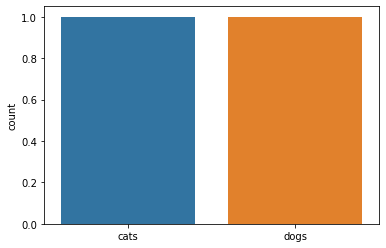

In [11]:
labels = pd.DataFrame(data=target, columns=['label'])
counts = labels.value_counts()
sns.countplot(data=counts,x=['cats','dogs'])

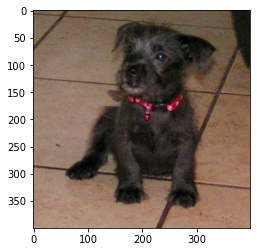

In [12]:
index= random.randint(0,24999)
im = cv2.imread(train_filepath[index])
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
img = im
plt.imshow(img)

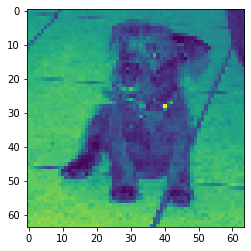

In [13]:
plt.figure()
plt.imshow(data[index].reshape(64,64))
plt.grid(False)
plt.show()

In [14]:
print("Number of missing values in the df:",df.isnull().any().sum())

Number of missing values in the df: 0


In [15]:
print("Number of missing values in the target set:",target.isnull().any().sum())

Number of missing values in the target set: 0


## Preprocessing 

In [16]:
# Adding the target dataframe to the images dataframe, just to see that the target values actually matches.
df = pd.concat([df, target], axis=1)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,4087,4088,4089,4090,4091,4092,4093,4094,4095,labels
0,19,47,26,58,49,73,70,68,71,73,...,53,36,30,34,41,51,54,58,52,1.0
1,96,104,114,112,110,111,111,113,116,115,...,98,141,117,121,120,113,107,26,49,0.0
2,70,157,180,181,189,164,141,146,149,198,...,110,112,95,93,87,85,81,68,68,1.0
3,26,25,26,28,27,27,35,28,28,27,...,22,35,30,39,36,26,52,46,42,0.0
4,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,0.0


In [17]:
df['labels'].value_counts()

0.0    12500
1.0    12500
Name: labels, dtype: int64

<B> We can see that the data is balanced, so now we can start training the model.
    

In [18]:
# Droping the labels in order to get the target of the data.
train = df.drop(["labels"], axis = 1)
# Split the data to train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train, target, test_size=0.3, random_state=0)

In [19]:
print("The train set as:",len(X_train),"Samples")

The train set as: 17500 Samples


In [20]:
print("The test set as:",len(X_test),"Samples")

The test set as: 7500 Samples


In [21]:
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)
# All the features have values between 0 to 255 so we normalize the data by dividing by 255.
X_train/=255.
X_test/=255.

<B> Lets try some models

### KNN

In [41]:
from sklearn.neighbors import KNeighborsClassifier
k_range = list(range(1, 50))
acc = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    neigh_pred = knn.predict(X_test)
    acc.append(metrics.accuracy_score(y_test, neigh_pred))
acc

[0.5505333333333333,
 0.5374666666666666,
 0.5624,
 0.5437333333333333,
 0.5653333333333334,
 0.5565333333333333,
 0.5742666666666667,
 0.5624,
 0.5762666666666667,
 0.5669333333333333,
 0.5792,
 0.5730666666666666,
 0.5848,
 0.5766666666666667,
 0.586,
 0.5777333333333333,
 0.5904,
 0.5821333333333333,
 0.5937333333333333,
 0.5852,
 0.5969333333333333,
 0.5901333333333333,
 0.5965333333333334,
 0.5908,
 0.5986666666666667,
 0.5912,
 0.5964,
 0.5932,
 0.594,
 0.5909333333333333,
 0.5945333333333334,
 0.5913333333333334,
 0.5969333333333333,
 0.592,
 0.5981333333333333,
 0.5938666666666667,
 0.6001333333333333,
 0.5956,
 0.6021333333333333,
 0.6012,
 0.6033333333333334,
 0.5992,
 0.6030666666666666,
 0.5958666666666667,
 0.6034666666666667,
 0.5990666666666666,
 0.6004,
 0.6002666666666666,
 0.6048]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.58      0.71      0.64      3728
         1.0       0.64      0.50      0.56      3772

    accuracy                           0.60      7500
   macro avg       0.61      0.61      0.60      7500
weighted avg       0.61      0.60      0.60      7500

Accuracy: 0.6048


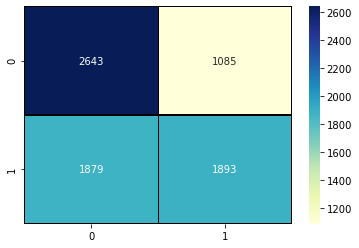

In [54]:
# We got the highest score with 49 neighbors.
confMatrix = confusion_matrix(y_test, neigh_pred)
sns.heatmap(confMatrix, annot=True, fmt="d",linecolor='black',linewidths=.2,cmap="YlGnBu")
result1 = classification_report(y_test, neigh_pred,zero_division=1)
print("Classification Report:",)
print (result1)
result2 = accuracy_score(y_test,neigh_pred)
print("Accuracy:",result2)

### Logistic Regression

In [55]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0)
clf.fit(X_train,y_train)
clf_pred=clf.predict(X_test)

In [56]:
metrics.accuracy_score(y_test,clf_pred)

0.5452

Classification Report:
              precision    recall  f1-score   support

         0.0       0.54      0.56      0.55      3728
         1.0       0.55      0.53      0.54      3772

    accuracy                           0.55      7500
   macro avg       0.55      0.55      0.55      7500
weighted avg       0.55      0.55      0.55      7500

Accuracy: 0.5452


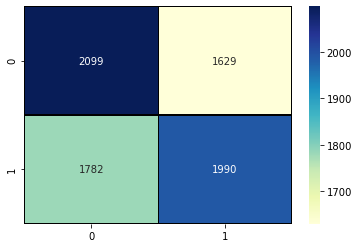

In [60]:
confMatrix = confusion_matrix(y_test, clf_pred)
sns.heatmap(confMatrix, annot=True, fmt="d",linecolor='black',linewidths=.2,cmap="YlGnBu")
result1 = classification_report(y_test, clf_pred,zero_division=1)
print("Classification Report:",)
print (result1)
result2 = accuracy_score(y_test,clf_pred)
print("Accuracy:",result2)

### Random Forest Classifier

In [57]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=10)
rf.fit(X_train, y_train)
rf_pred=rf.predict(X_test)

In [58]:
metrics.accuracy_score(y_test,rf_pred)

0.6474666666666666

Classification Report:
              precision    recall  f1-score   support

         0.0       0.63      0.70      0.66      3728
         1.0       0.67      0.60      0.63      3772

    accuracy                           0.65      7500
   macro avg       0.65      0.65      0.65      7500
weighted avg       0.65      0.65      0.65      7500

Accuracy: 0.6474666666666666


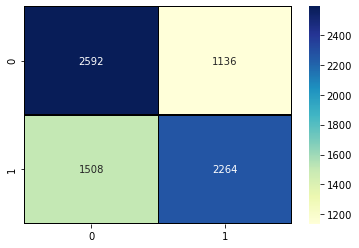

In [59]:
confMatrix = confusion_matrix(y_test, rf_pred)
sns.heatmap(confMatrix, annot=True, fmt="d",linecolor='black',linewidths=.2,cmap="YlGnBu")
result1 = classification_report(y_test, rf_pred,zero_division=1)
print("Classification Report:",)
print (result1)
result2 = accuracy_score(y_test,rf_pred)
print("Accuracy:",result2)

### xgboost

In [62]:
import xgboost
xgb=xgboost.XGBClassifier(n_estimators=150,eval_metric='mlogloss')
xgb.fit(X_train,y_train)
xgb_p=xgb.predict(X_test)

In [63]:
metrics.accuracy_score(y_test,xgb_p)

0.6702666666666667

Classification Report:
              precision    recall  f1-score   support

         0.0       0.67      0.68      0.67      3728
         1.0       0.68      0.66      0.67      3772

    accuracy                           0.67      7500
   macro avg       0.67      0.67      0.67      7500
weighted avg       0.67      0.67      0.67      7500

Accuracy: 0.6702666666666667


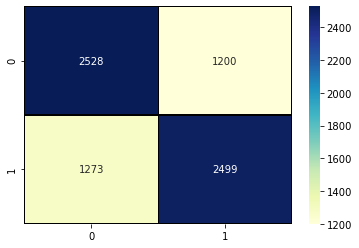

In [64]:
confMatrix = confusion_matrix(y_test, xgb_p)
sns.heatmap(confMatrix, annot=True, fmt="d",linecolor='black',linewidths=.2,cmap="YlGnBu")
result1 = classification_report(y_test, xgb_p,zero_division=1)
print("Classification Report:",)
print (result1)
result2 = accuracy_score(y_test,xgb_p)
print("Accuracy:",result2)